In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [72]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func, distinct

In [73]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [74]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\mholman\AppData\Local\Temp\ipykernel_6404\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [75]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [76]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [77]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [78]:
# Find the most recent date in the data set.
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')  

recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [79]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

latest_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)
print(start_date)

2016-08-23 00:00:00


In [80]:
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date

series = [Measurement.date, 
       func.sum(Measurement.prcp)]
precipitation = session.query(*series).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

precipitation_df = pd.DataFrame(precipitation, columns=['measurement_date', 'precipitation_amount'])
precipitation_df.dropna(axis=0, how='any', inplace= True)
precipitation_df.sort_values(by='measurement_date')
precipitation_df.set_index('measurement_date', inplace=True)
precipitation_df.head(5)


,precipitation_amount
measurement_date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


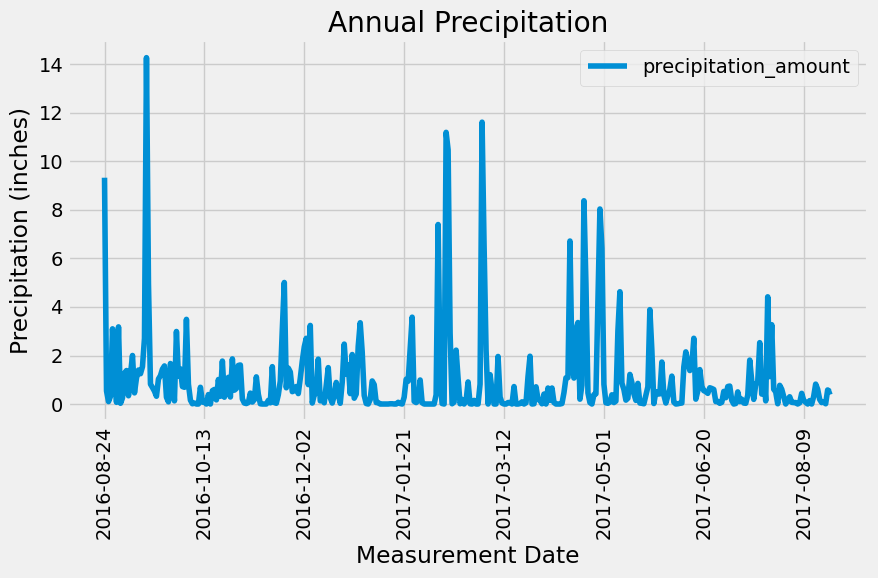

In [81]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(rot=90, title='Annual Precipitation', xlabel='Measurement Date', ylabel = "Precipitation (inches)", figsize=(9,6))
plt.tight_layout()
plt.show()
ax.figure.savefig('Annual_Precipitation.png', bbox_inches='tight')

In [82]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation_amount
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [83]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(distinct(Measurement.station))).all()

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
series = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*series).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [94]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
series = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
most_active_station = session.query(*series).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in most_active_station:
    print(station)

(54.0, 85.0, 71.66378066378067)


In [96]:
# Using the most active station id
series = [Measurement.date, 
       Measurement.tobs]
station_temp = session.query(*series).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Create a datafrem containing the results of this query
station_temp_df = pd.DataFrame(station_temp, columns=['Measurement Date', 'Temperature'])
station_temp_df.head()

,Measurement Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


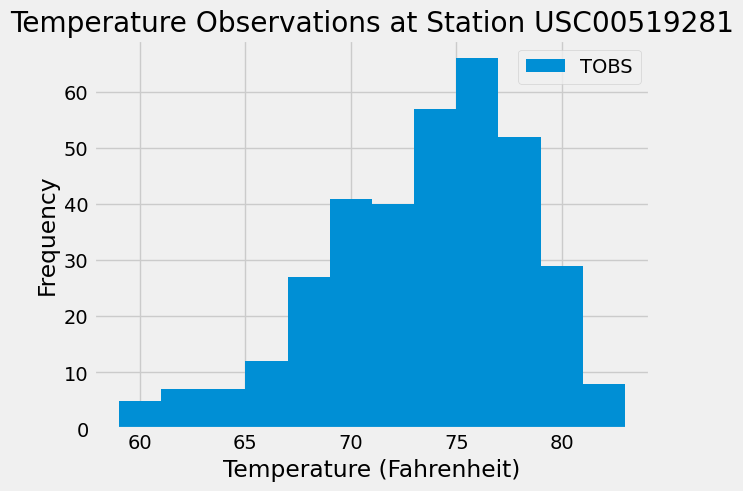

In [101]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(station_temp_df['Temperature'],bins=12, label="TOBS")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at Station USC00519281")
plt.figsize=(12,9)
plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()

# Close Session

In [102]:
# Close Session
session.close()